In [1]:
# To-dos:
    # Ao buscar o matchID dá pra criar uma coluna data do jogo tb

## Imports

In [9]:
import os
import sys

import pandas as pd
import json
pd.set_option('display.max_columns', None)

from tqdm import tqdm

import socceraction.spadl as spd
import socceraction.spadl.wyscout as wyscout
import matplotsoccer
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
from mplsoccer import Pitch, Sbopen, VerticalPitch

from scipy.spatial.distance import pdist, squareform
import numpy as np

## Load Data

In [10]:
# Premier League 2017-2018
def loadData(dataname):
  path = os.path.join(dataname)
  with open(path) as f:
      data = json.load(f)

  return pd.DataFrame(data)

In [11]:
df_events = loadData(f'files/events_England.json')

df_teams = loadData(f'files/teams.json')
df_teams['officialName'] = df_teams['officialName'].str.decode('unicode-escape')
df_merge = pd.merge(df_events, df_teams, left_on='teamId', right_on='wyId', how='left')

# carregando as partidas, pois vamos saber quais times jogam em casa e fora p/ usar como parametro do SPADL
matches = loadData(f'files/matches_England.json')

players = loadData('files/players.json')

In [12]:
display(df_events.head())

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [13]:
df_events['subEventName'].unique()

array(['Simple pass', 'High pass', 'Head pass', 'Air duel',
       'Ground loose ball duel', 'Smart pass', 'Launch',
       'Ground defending duel', 'Ground attacking duel', 'Foul',
       'Free Kick', 'Cross', 'Shot', 'Reflexes', 'Touch', 'Clearance',
       'Ball out of the field', 'Throw in', 'Goal kick', 'Corner',
       'Goalkeeper leaving line', 'Hand pass', 'Acceleration',
       'Save attempt', '', 'Free kick cross', 'Free kick shot',
       'Hand foul', 'Violent Foul', 'Protest', 'Whistle',
       'Late card foul', 'Out of game foul', 'Penalty', 'Time lost foul',
       'Simulation'], dtype=object)

In [14]:
display(df_teams.head())

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [15]:
display(matches.head())

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364


In [16]:
display(players.head())

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null


## Premier League p/ SPADL

In [10]:
# # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
# events = df_events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
#                                 'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})

# events['milliseconds'] = events['eventSec'] * 1000
# events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

In [11]:
# # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
# team_matches = []

# for i in tqdm(range(len(matches))):
#     match = pd.DataFrame(matches.loc[i, 'teamsData']).T
#     match['matchId'] = matches.loc[i, 'wyId']
#     team_matches.append(match)

# team_matches = pd.concat(team_matches).reset_index(drop=True)

# team_matches.head()

In [12]:
# # fazendo a conversão p/ SPADL, padronizando a direção de jogo da esquerda p/ a direita e adicionando os nomes dos tipos de ações
# spadl = []
# game_ids = events.game_id.unique().tolist()

# for g in tqdm(game_ids):
#     match_events = events.loc[events.game_id == g]
#     match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]

#     match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
#     match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
#     match_actions = spd.add_names(match_actions)
    
#     spadl.append(match_actions)

# spadl = pd.concat(spadl).reset_index(drop=True)

In [13]:
# # Merge with players name

# players['player_name'] = players['firstName'] + ' ' + players['lastName']
# players['player_name'] = players['player_name'].str.decode('unicode-escape')
# players = players[['wyId', 'player_name']].rename(columns={'wyId': 'player_id'})

# spadl = spadl.merge(players, on='player_id', how='left')

In [14]:
# # Merge with teams name
# teams = df_teams[['wyId', 'name']].rename(columns={'wyId': 'team_id'})

# spadl = spadl.merge(teams, on='team_id', how='left')

In [15]:
# spadl.head()

In [16]:
# spadl.type_name.unique()

## Data Visualization

In [17]:
final_position = ['Manchester City', 'Manchester United', 'Tottenham Hotspur', 'Liverpool', 'Chelsea', 
                'Arsenal', 'Burnley', 'Everton', 'Leicester City', 'Newcastle United', 'Crystal Palace',
                'AFC Bournemouth', 'West Ham United', 'Watford', 'Brighton & Hove Albion', 'Huddersfield Town', 
                'Southampton', 'Swansea City', 'Stoke City', 'West Bromwich Albion']

### Ploting Passes

In [18]:
# Countig number o pass by teams
df_filtered = df_merge[df_merge['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Hand pass'])]

df_passes_events = pd.pivot_table(df_filtered, index='name', columns='subEventName', aggfunc='size', fill_value=0)

df_passes_events['total'] = df_passes_events.sum(axis=1)
df_passes_events['mean'] = df_passes_events['total'] // 38

df_passes_events = df_passes_events.reset_index()
test_passes = df_passes_events[['name', 'total', 'mean']].copy()

# Sorting by final table
test_passes.name = test_passes.name.astype("category")
test_passes.name = test_passes.name.cat.set_categories(final_position)

test_passes = test_passes.sort_values(["name"])[['name', 'total', 'mean']]
test_passes = test_passes[::-1]
test_passes

subEventName,name,total,mean
18,West Bromwich Albion,11213,295
14,Stoke City,10716,282
15,Swansea City,13781,362
13,Southampton,15342,403
7,Huddersfield Town,12899,339
2,Brighton & Hove Albion,12831,337
17,Watford,13651,359
19,West Ham United,12410,326
0,AFC Bournemouth,14348,377
5,Crystal Palace,12359,325


In [19]:
# Criação do gráfico de barras
fig = go.Figure(data=go.Bar(x=test_passes['mean'], y=test_passes['name'], orientation='h'))

# Configurações do layout
fig.update_layout(xaxis_title='Number of Passes',
                  yaxis_title='Team',
        		  autosize=False,
         		  width=1000,
   				  height=700)

# Exibição do gráfico
fig.show()

### Ploting Shots

In [20]:
listEvents = ['Free kick shot', 'Shot']
df_filtered = df_merge[df_merge['subEventName'].isin(listEvents)]

df_shots_events = pd.pivot_table(df_filtered, index='name', columns='subEventName', aggfunc='size', fill_value=0)
df_shots_events['total'] = df_shots_events.sum(axis=1)

df_shots_events['mean'] = df_shots_events['total'] // 38

df_shots_events = df_shots_events.reset_index()
test_shots = df_shots_events[['name', 'total', 'mean']].copy()

# Sorting by final table
test_shots.name = test_shots.name.astype("category")
test_shots.name = test_shots.name.cat.set_categories(final_position)

test_shots = test_shots.sort_values(["name"])[['name', 'total', 'mean']]
test_shots = test_shots[::-1]
test_shots

subEventName,name,total,mean
18,West Bromwich Albion,368,9
14,Stoke City,367,9
15,Swansea City,321,8
13,Southampton,426,11
7,Huddersfield Town,340,8
2,Brighton & Hove Albion,359,9
17,Watford,416,10
19,West Ham United,343,9
0,AFC Bournemouth,431,11
5,Crystal Palace,445,11


In [21]:
# Criação do gráfico de barras
fig = go.Figure(data=go.Bar(x=test_shots['mean'], y=test_shots['name'], orientation='h'))

# Configurações do layout
fig.update_layout(xaxis_title='Number of Shots',
                  yaxis_title='Team',
        		  autosize=False,
         		  width=1000,
   				  height=700)

# Exibição do gráfico
fig.show()

## Heatmaps e Mapa de Passes

In [24]:
# load pre-processed SPADL from Json
# spadl.to_json('spadl.json')
spadl = pd.read_json('files/spadl.json')

In [25]:
spadl.shape

(482901, 19)

### Filtering Passes Actions

In [26]:
passes = pd.DataFrame(spadl.loc[(spadl.type_name == 'pass')])
passes.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,name
0,2499719,1,2.758649,1609,25413,51.45,34.68,32.55,14.96,177959171.0,0,0,1,0,pass,success,foot,Alexandre Lacazette,Arsenal
1,2499719,1,4.946850,1609,370224,32.55,14.96,53.55,17.00,177959172.0,0,0,1,1,pass,success,foot,Rob Holding,Arsenal
2,2499719,1,6.542188,1609,3319,53.55,17.00,36.75,19.72,177959173.0,1,0,1,2,pass,success,head,Mesut Özil,Arsenal
3,2499719,1,8.143395,1609,120339,36.75,19.72,43.05,3.40,177959174.0,1,0,1,3,pass,success,head,Mohamed Naser Elsayed Elneny,Arsenal
4,2499719,1,10.302366,1609,167145,43.05,3.40,75.60,8.16,177959175.0,0,0,1,4,pass,success,foot,Héctor Bellerín Moruno,Arsenal


### Ploting Heatmaps

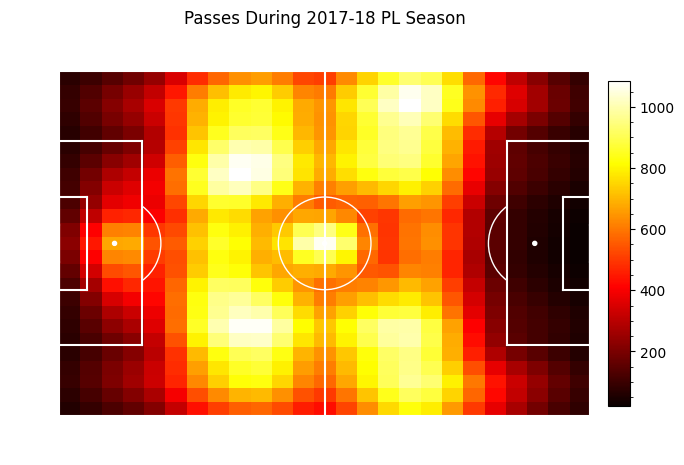

In [27]:
# Heatmap das zonas iniciais dos passes de todos os times no campeonato
x = passes.start_x
y = passes.start_y

hm = matplotsoccer.count(x, y, n = 25, m = 25)
hm = gaussian_filter(hm, 1)

matplotsoccer.heatmap(matrix = hm, cmap="hot", linecolor="white", cbar=True, show=False, figsize=8)
plt.title("Passes During 2017-18 PL Season")
plt.show()

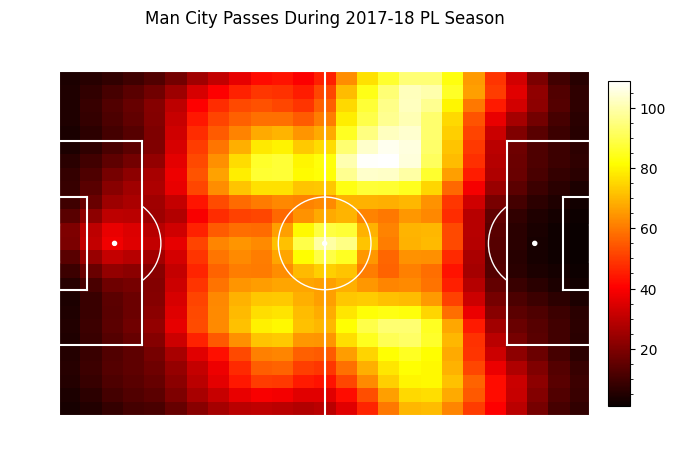

In [28]:
# Heatmap das zonas iniciais dos passes de todos os times no campeonato
x = passes[passes['name'] == 'Manchester City'].start_x
y = passes[passes['name'] == 'Manchester City'].start_y

hm = matplotsoccer.count(x, y, n = 25, m = 25)
hm = gaussian_filter(hm, 1)

matplotsoccer.heatmap(matrix = hm, cmap="hot", linecolor="white", cbar=True, show=False, figsize=8)
plt.title("Man City Passes During 2017-18 PL Season")
plt.show()

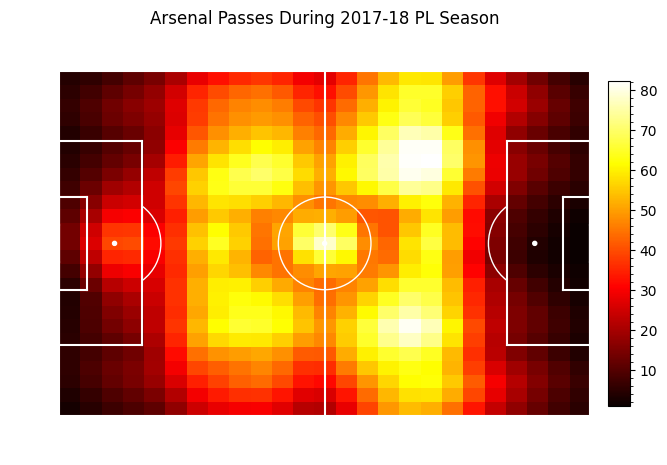

In [29]:
# Heatmap das zonas iniciais dos passes de todos os times no campeonato
x = passes[passes['name'] == 'Arsenal'].start_x
y = passes[passes['name'] == 'Arsenal'].start_y

hm = matplotsoccer.count(x, y, n = 25, m = 25)
hm = gaussian_filter(hm, 1)

matplotsoccer.heatmap(matrix = hm, cmap="hot", linecolor="white", cbar=True, show=False, figsize=8)
plt.title("Arsenal Passes During 2017-18 PL Season")
plt.show()

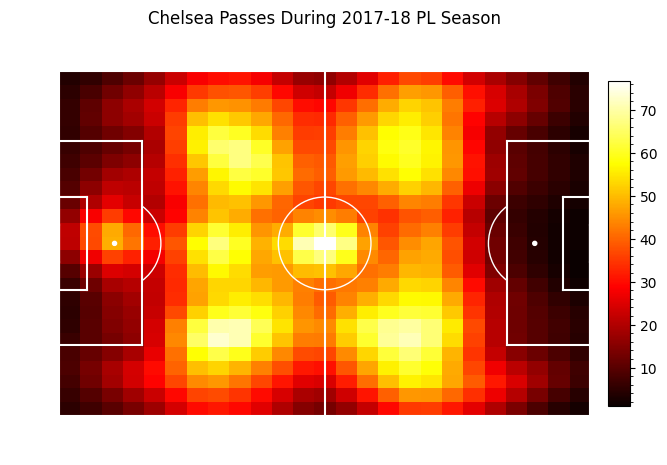

In [30]:
# Heatmap das zonas iniciais dos passes de todos os times no campeonato
x = passes[passes['name'] == 'Chelsea'].start_x
y = passes[passes['name'] == 'Chelsea'].start_y

hm = matplotsoccer.count(x, y, n = 25, m = 25)
hm = gaussian_filter(hm, 1)

matplotsoccer.heatmap(matrix = hm, cmap="hot", linecolor="white", cbar=True, show=False, figsize=8)
plt.title("Chelsea Passes During 2017-18 PL Season")
plt.show()

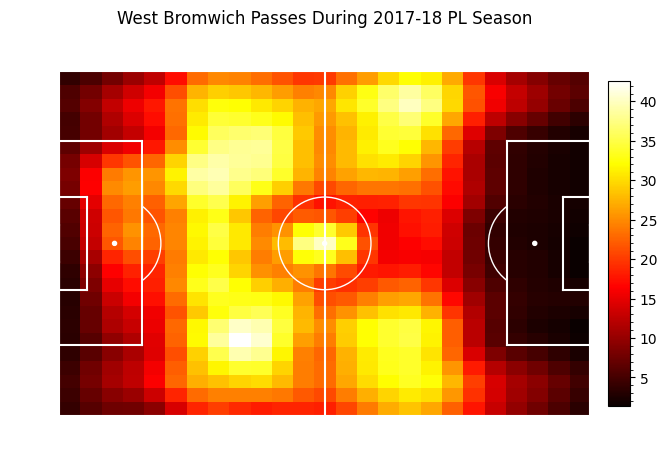

In [31]:
# Heatmap das zonas iniciais dos passes de todos os times no campeonato
x = passes[passes['name'] == 'West Bromwich Albion'].start_x
y = passes[passes['name'] == 'West Bromwich Albion'].start_y

hm = matplotsoccer.count(x, y, n = 25, m = 25)
hm = gaussian_filter(hm, 1)

matplotsoccer.heatmap(matrix = hm, cmap="hot", linecolor="white", cbar=True, show=False, figsize=8)
plt.title("West Bromwich Passes During 2017-18 PL Season")
plt.show()

### Ploting Passes Map

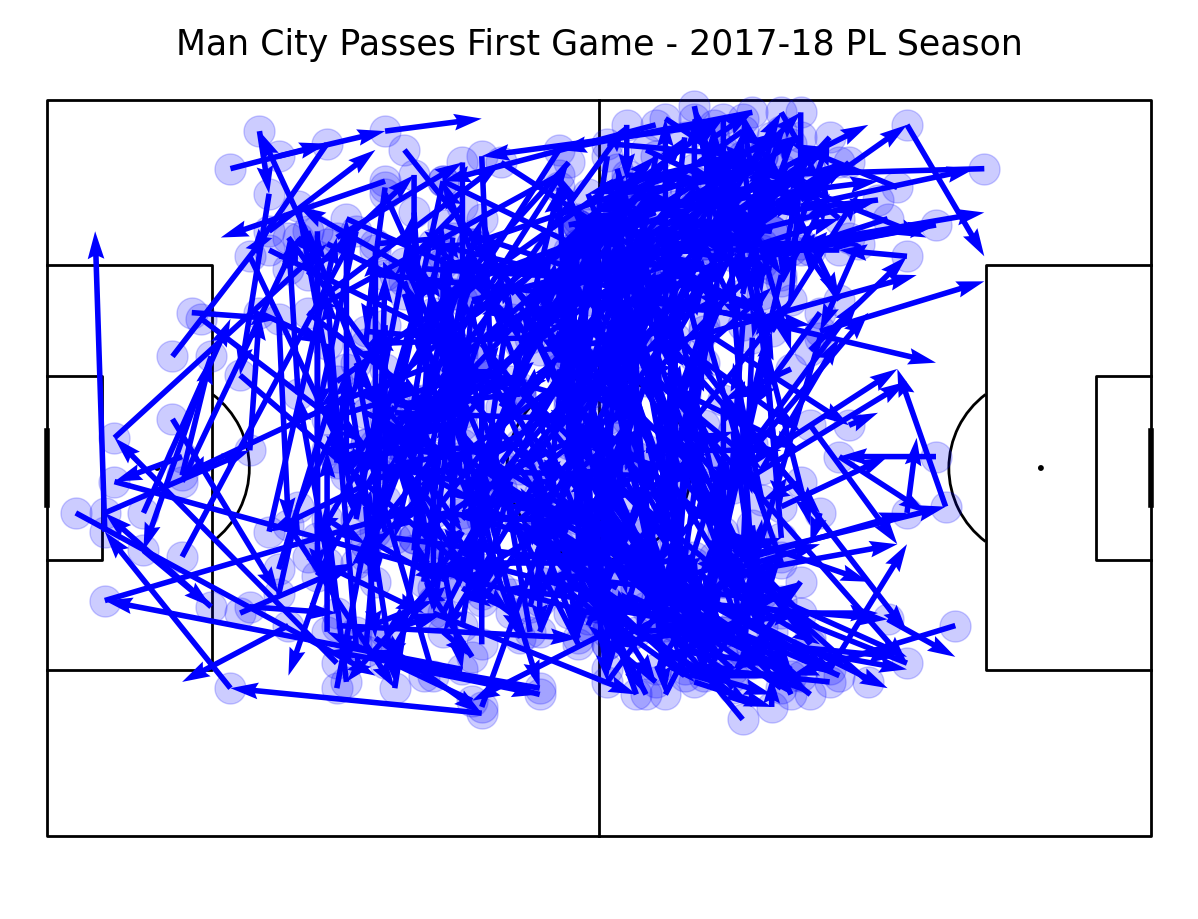

In [32]:
# Mapa de Passes Primeiro jogo Man City
df_passes = passes[(passes["name"] == "Manchester City") & (passes["result_name"] == "success") & (passes['game_id'] == 2499720)].copy()

pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pitch.arrows(df_passes.start_x, df_passes.start_y, df_passes.end_x, df_passes.end_y, color = "blue", ax=ax['pitch'])

pitch.scatter(df_passes.start_x, df_passes.start_y, alpha = 0.2, s = 500, color = "blue", ax=ax['pitch'])
fig.suptitle("Man City Passes First Game - 2017-18 PL Season", fontsize = 25)

plt.show()

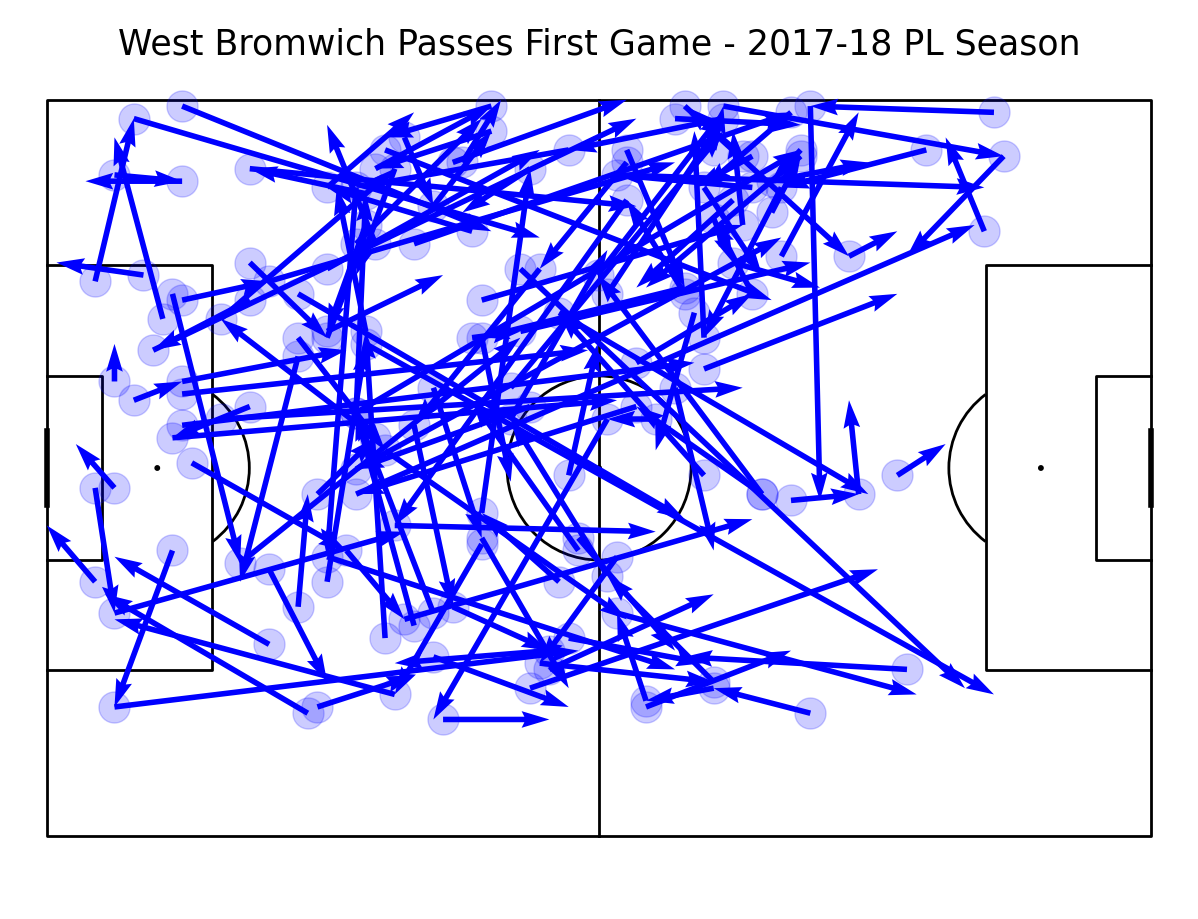

In [33]:
# Mapa de Passes Primeiro jogo West Bromwich
df_passes = passes[(passes["name"] == "West Bromwich Albion") & (passes["result_name"] == "success") & (passes['game_id'] == 2499728)].copy()

pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pitch.arrows(df_passes.start_x, df_passes.start_y, df_passes.end_x, df_passes.end_y, color = "blue", ax=ax['pitch'])

pitch.scatter(df_passes.start_x, df_passes.start_y, alpha = 0.2, s = 500, color = "blue", ax=ax['pitch'])
fig.suptitle("West Bromwich Passes First Game - 2017-18 PL Season", fontsize = 25)

plt.show()

## Visualizing Style Similarity

### Group by passes by teams

In [34]:
team_passes_groups = passes.groupby('name')

In [35]:
len(team_passes_groups.get_group('Manchester United'))

19076

### Creating 10 randomly subsamples of passes from each Team

In [36]:
num_subsamples = 10
teams_subsamples_passes = {}

for team in (final_position):
    subsamples = []  # List to store the subsamples

    for _ in range(num_subsamples):
        subsample = team_passes_groups.get_group(team)[['start_x', 'start_y', 'end_x', 'end_y', 'name']]\
                    .sample(n=len(team_passes_groups.get_group(team)) // 10)

        subsamples.append(subsample)
    
    teams_subsamples_passes[team] = subsamples

# Displaying the subsamples
# for i, subsample in enumerate(subsamples):
#     print(f"Subsample {i+1}:")
#     display(subsample)

In [37]:
# 1 Subsample example of Man City team
teams_subsamples_passes['Manchester City'][0]

,start_x,start_y,end_x,end_y,name
399846,35.70,64.60,48.30,65.28,Manchester City
345358,26.25,63.92,10.50,59.16,Manchester City
439735,29.40,28.56,49.35,24.48,Manchester City
205775,60.90,23.80,66.15,5.44,Manchester City
274284,68.25,13.60,69.30,5.44,Manchester City
...,...,...,...,...,...
363174,61.95,46.24,55.65,46.92,Manchester City
273834,66.15,54.40,49.35,55.76,Manchester City
465888,86.10,52.36,92.40,62.56,Manchester City
77591,22.05,39.44,36.75,48.96,Manchester City


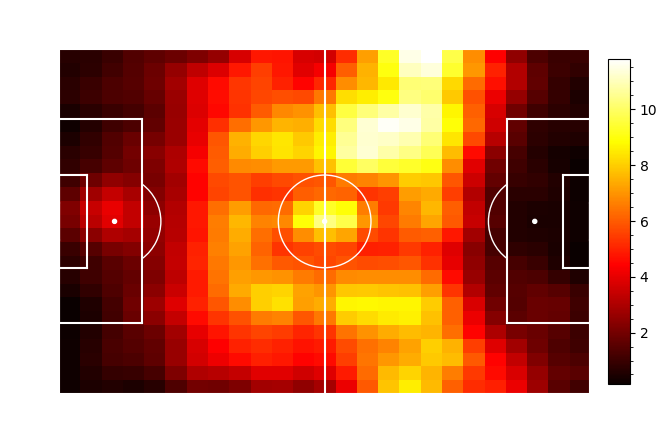

In [38]:
hm = matplotsoccer.count(teams_subsamples_passes['Manchester City'][0].start_x, teams_subsamples_passes['Manchester City'][0].start_y, n = 25, m = 25)
hm = gaussian_filter(hm, 1)

matplotsoccer.heatmap(matrix = hm, linecolor="white", cmap="hot", cbar=True, show=False, figsize=8);

In [39]:
# Creating 10 heatmaps for all teams
df_list = []
teams = []

for team in (final_position):
    for i in range(num_subsamples):
        hm = matplotsoccer.count(teams_subsamples_passes[team][i].start_x, teams_subsamples_passes[team][i].start_y, n = 25, m = 25)
        hm = gaussian_filter(hm, 1)

        df_list.append(hm.flatten())    # Converting (25,25) heatmaps to 1D array of (625,)
        teams.append(team)


In [40]:
distances = pdist(df_list, metric='euclidean')
distances.shape

(19900,)

In [41]:
dist_matrix = squareform(distances)
dist_matrix.shape

(200, 200)

In [42]:
# Normalizing distance (0,1)
dist_df = pd.DataFrame(dist_matrix, index=teams, columns=teams)
dist_df /= np.max(dist_df.values)
dist_df.shape

(200, 200)

In [43]:
# We need 20x20 matrix: take mean from rows (10:200:10)
df_distance_mean_row = []

for index, row in dist_df.iterrows():
    tmp = []
    j = 0

    for i in range(9, 200, 10):
        tmp.append(np.mean(row.values[j:i]))
        j += 10
    
    df_distance_mean_row.append(tmp)

In [45]:
df_distance_mean_col = pd.DataFrame(df_distance_mean_row, index=teams, columns=final_position)
df_distance_mean_col.shape

(200, 20)

In [46]:
# We need 20x20 matrix: take mean from columns (10:200:10)
df_distance_mean = []

for (index, col) in df_distance_mean_col.items():
    tmp = []
    j = 0

    for i in range(9, 200, 10):
        tmp.append(np.mean(col.values[j:i]))
        j += 10
    
    df_distance_mean.append(tmp)

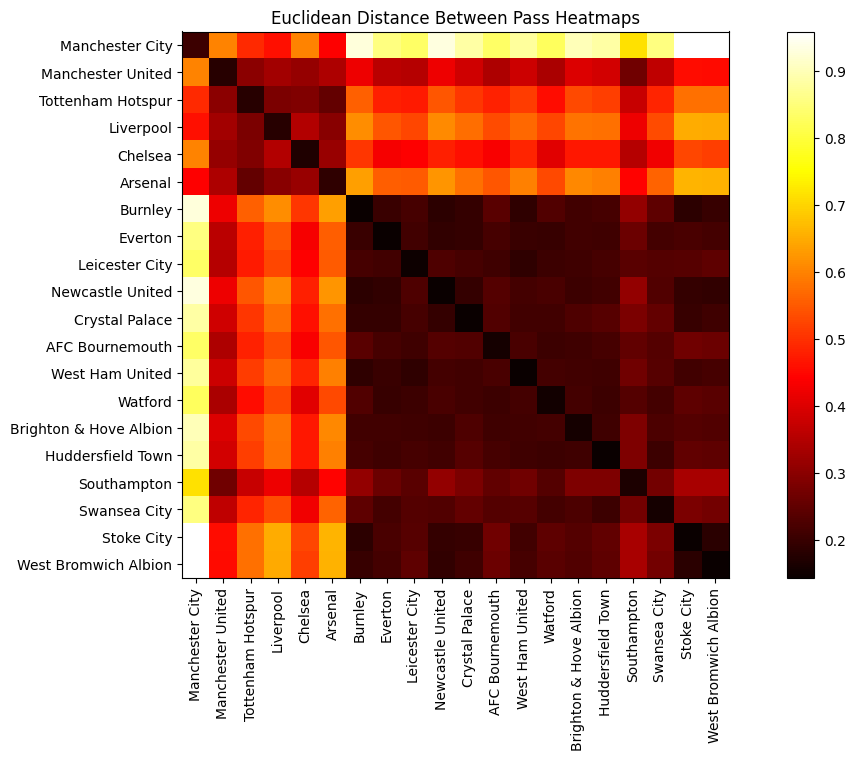

In [47]:
fig, ax = plt.subplots(figsize=(12,6))
im = plt.imshow(df_distance_mean, cmap='hot', interpolation='nearest')
fig.tight_layout()

plt.colorbar()
plt.xticks(np.arange(len(df_distance_mean)), df_distance_mean_col.columns, rotation=90)
plt.yticks(np.arange(len(df_distance_mean)), df_distance_mean_col.columns)

plt.title('Euclidean Distance Between Pass Heatmaps')
plt.show();

### Temp

In [48]:
# Get actions by game
team_passes_groups.get_group('Arsenal')['game_id'].unique()
team_passes_groups.get_group('Arsenal')[team_passes_groups.get_group('Arsenal')['game_id'] == 2499735]

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,name
19393,2499735,1,2.146058,1609,25413,52.50,33.32,40.95,35.36,180058634.0,0,0,1,0,pass,success,foot,Alexandre Lacazette,Arsenal
19394,2499735,1,4.300831,1609,49876,40.95,35.36,29.40,35.36,180058635.0,0,0,1,1,pass,success,foot,Granit Xhaka,Arsenal
19395,2499735,1,6.191641,1609,3560,29.40,35.36,30.45,55.08,180058638.0,0,0,1,2,pass,success,foot,Ignacio Monreal Eraso,Arsenal
19396,2499735,1,7.886868,1609,14869,30.45,55.08,29.40,34.68,180058636.0,0,0,1,3,pass,success,foot,Sead Kolašinac,Arsenal
19397,2499735,1,10.614739,1609,3560,29.40,34.68,17.85,10.20,180058637.0,0,0,1,4,pass,success,foot,Ignacio Monreal Eraso,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20691,2499735,2,2980.312038,1609,230020,46.20,55.08,69.30,65.96,180060462.0,0,0,1,1298,pass,success,foot,Alex Iwobi,Arsenal
20692,2499735,2,2983.595861,1609,167145,69.30,65.96,81.90,65.96,180060463.0,0,0,1,1299,pass,success,foot,Héctor Bellerín Moruno,Arsenal
20693,2499735,2,2985.229324,1609,7945,81.90,65.96,68.25,51.68,180060464.0,0,0,1,1300,pass,success,foot,Daniel Nii Tackie Mensah Welbeck,Arsenal
20694,2499735,2,2989.277422,1609,230020,68.25,51.68,94.50,31.96,180060465.0,0,0,1,1301,pass,success,foot,Alex Iwobi,Arsenal
